In [1]:
"""Script to compare the EKF and SI to the batch ref traj.
Developed for investigating lateral tracker errors with the EKF.
"""

import math

import matplotlib.pyplot as plt
import numpy as np

from base.geometry.isometry3d_py import Isometry3d
from base.math.angles import shortestAngularDistance
from data.tools import zed

In [4]:
RUNID="20210219T225603-kitt_41"
RANGE=RUNID+"@1613775443-1613775488"

def get_uri(var):
    return "chum://{}?i=/home/brice/tmp/ekf_eval/{},$default&v={}".format(RANGE, RUNID, var)

def get_hero_state(uri=None, hs=None):
    if hs is not None:
        return hs
    assert uri is not None
    reader = zed.from_chum(uri, topics=["/planner/hero_state"])
    return reader.planner_hero_state[:]

def load_vel(uri=None, hs=None):
    hs = get_hero_state(uri, hs)    
    return {
        "t": hs.body_velocity.time.nanoseconds * 1e-9,
        "vx": hs.body_velocity.v_x,
        "vy": hs.body_velocity.v_y,
        "vz": hs.body_velocity.v_z,
    }
    
def load_global_pose(uri=None, hs=None):
    hs = get_hero_state(uri, hs)
    return {
        "t": hs.pose.time.nanoseconds * 1e-9,
        "x": hs.pose.x - hs.local_utm_t_utm.x,
        "y": hs.pose.y - hs.local_utm_t_utm.y,
        "z": hs.pose.z - hs.local_utm_t_utm.z,
    }
    
def load_smooth_pose(uri=None, hs=None):
    hs = get_hero_state(uri, hs)
    first_pose = None
    res = {
        "t": [],
        "x": [],
        "y": [],
        "z": [],
        "roll": [],
        "pitch": [],
        "yaw": [],
    }
    for i in range(len(hs)):
        p = Isometry3d(np.asarray([
                hs.smooth_t_baselink.x[i], 
                hs.smooth_t_baselink.y[i], 
                hs.smooth_t_baselink.z[i], 
                hs.smooth_t_baselink.roll[i], 
                hs.smooth_t_baselink.pitch[i], 
                hs.smooth_t_baselink.yaw[i],
            ]))
        if first_pose is None:
            first_pose = p
        else:
            p = first_pose.inverse() * p
            res["t"].append(hs.smooth_t_baselink.time.nanoseconds[i] * 1e-9)
            res["x"].append(p.translation()[0])
            res["y"].append(p.translation()[1])
            res["z"].append(p.translation()[2])
            res["roll"].append(p.rotation_rpy()[0])
            res["pitch"].append(p.rotation_rpy()[1])
            res["yaw"].append(p.rotation_rpy()[2])
            
    for k in res:
        res[k] = np.array(res[k])
        
    return res

def rms(e):
    return math.sqrt(np.square(e).mean())

def plot_traj(var, traj_key):
    plt.plot(data[var][traj_key]["x"], data[var][traj_key]["y"], label=var, color=data[var]["color"])

def diff(d, ref, axis):
    return np.interp(ref["t"], d["t"], d[axis]) - ref[axis]

def traj_diff(d, ref):
    return np.hypot(diff(d, ref, "x"), diff(d, ref, "y"))

def angle_diff(d, ref, axis):
    D = np.interp(ref["t"], d["t"], d[axis])
    return np.asarray([shortestAngularDistance(D[i], ref[axis][i]) for i in range(len(D))])

def vy_diff(d, ref):
    return np.interp(ref["v"]["t"], d["v"]["t"], d["v"]["vy"]) - ref["v"]["vy"]

In [3]:
data = {
    "batch": {
        "uri": get_uri("batch"),
        "color": "k",
    },    
    "si": {
        "uri": get_uri("si"),
        "color": "b",
    },
    "ekf": {
        "uri": get_uri("ekf"),
        "color": "r",
    },
}

for d in data.values():
    hs = get_hero_state(d["uri"])
    d["v"] = load_vel(hs=hs)
    d["p"] = load_global_pose(hs=hs)
    d["s"] = load_smooth_pose(hs=hs)

INFO:absl:Processing input...
INFO:absl:Loading 45.0 seconds of data.
INFO:absl:URI:
    vehicle: "kitt_41"
    start_time_ns: 1613775443000000000
    end_time_ns: 1613775488000000000
    start_time_format: kSecondsSinceEpoch
    end_time_format: kSecondsSinceEpoch
    input: "/home/brice/tmp/ekf_eval/20210219T225603-kitt_41"
    input: "$default"
    variant: "batch"
    
INFO:absl:Loading data for topic `/planner/hero_state` into attribute `planner_hero_state`
INFO:absl:Processing input...
INFO:absl:Loading 45.0 seconds of data.
INFO:absl:URI:
    vehicle: "kitt_41"
    start_time_ns: 1613775443000000000
    end_time_ns: 1613775488000000000
    start_time_format: kSecondsSinceEpoch
    end_time_format: kSecondsSinceEpoch
    input: "/home/brice/tmp/ekf_eval/20210219T225603-kitt_41"
    input: "$default"
    variant: "si"
    
INFO:absl:Loading data for topic `/planner/hero_state` into attribute `planner_hero_state`
INFO:absl:Processing input...
INFO:absl:Loading 45.0 seconds of data.

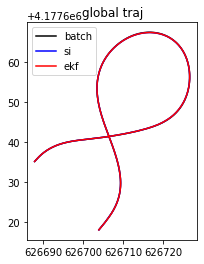

In [5]:
plot_traj(var="batch", traj_key="p")
plot_traj(var="si", traj_key="p")
plot_traj(var="ekf", traj_key="p")
plt.gca().set_aspect('equal', adjustable='box')
plt.title("global traj")
plt.legend()

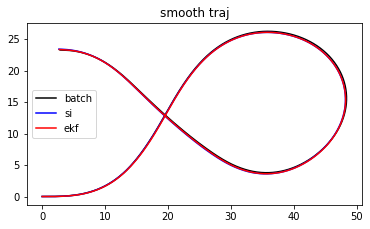

In [6]:
plot_traj(var="batch", traj_key="s")
plot_traj(var="si", traj_key="s")
plot_traj(var="ekf", traj_key="s")
plt.gca().set_aspect('equal', adjustable='box')
plt.title("smooth traj")
plt.legend()

In [7]:
# xy errors
si_traj_err = traj_diff(data["si"]["s"], data["batch"]["s"])
ekf_traj_err = traj_diff(data["ekf"]["s"], data["batch"]["s"])

print("SI smooth RMSE: {}".format(rms(si_traj_err)))
print("EKF smooth RMSE: {}".format(rms(ekf_traj_err)))

SI smooth RMSE: 0.22598600759237636
EKF smooth RMSE: 0.1631411081876474


Text(0.5, 1.0, 'smooth pose error')

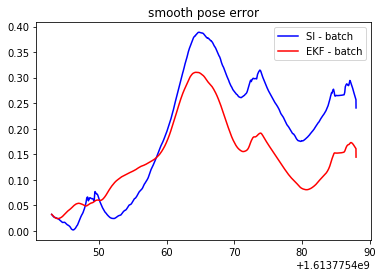

In [8]:
plt.plot(data["batch"]["s"]["t"], si_traj_err, label="SI - batch", color=data["si"]["color"])
plt.plot(data["batch"]["s"]["t"], ekf_traj_err, label="EKF - batch", color=data["ekf"]["color"])
plt.legend()
plt.title("smooth pose error")

In [9]:
# yaw errors
si_yaw_err = angle_diff(data["si"]["s"], data["batch"]["s"], "yaw")
ekf_yaw_err = angle_diff(data["ekf"]["s"], data["batch"]["s"], "yaw")
print("SI smooth RMSE: {}".format(rms(si_yaw_err)))
print("EKF smooth RMSE: {}".format(rms(ekf_yaw_err)))

SI smooth RMSE: 0.0019381111216560567
EKF smooth RMSE: 0.0019482045974609816


Text(0.5, 1.0, 'smooth yaw error (degrees)')

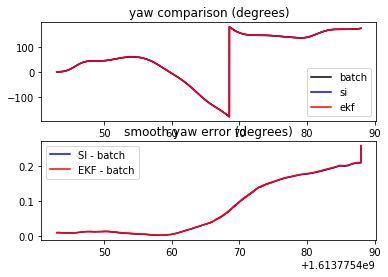

In [12]:
ax = plt.subplot(211)
for k, d in data.items():
    plt.plot(d["s"]["t"], np.degrees(d["s"]["yaw"]), label=k, color=d["color"])
plt.legend()
plt.title("yaw comparison (degrees)")
plt.subplot(212, sharex=ax)
plt.plot(data["batch"]["s"]["t"], np.degrees(si_yaw_err), label="SI - batch", color=data["si"]["color"])
plt.plot(data["batch"]["s"]["t"], np.degrees(ekf_yaw_err), label="EKF - batch", color=data["ekf"]["color"])
plt.legend()
plt.title("smooth yaw error (degrees)")

In [13]:
si_vy_err = vy_diff(data["si"], data["batch"])
ekf_vy_err = vy_diff(data["ekf"], data["batch"])
print("SI vy RMSE: {}".format(rms(si_vy_err)))
print("EKF vy RMSE: {}".format(rms(ekf_vy_err)))

SI vy RMSE: 0.02537121684223502
EKF vy RMSE: 0.017491705062466976


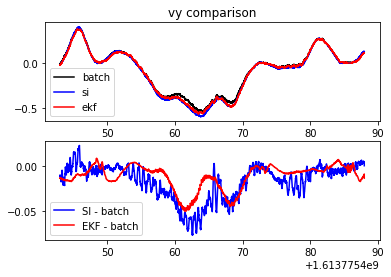

In [17]:
ax = plt.subplot(211)
for k, d in data.items():
    plt.plot(d["v"]["t"], d["v"]["vy"], label=k, color=d["color"])
plt.legend()
plt.title("vy comparison")
plt.subplot(212, sharex=ax)
plt.plot(data["batch"]["v"]["t"], si_vy_err, label="SI - batch", color=data["si"]["color"])
plt.plot(data["batch"]["v"]["t"], ekf_vy_err, label="EKF - batch", color=data["ekf"]["color"])
plt.legend()